In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sjoert.stellar
import pandas as pd
import os
from tqdm import tqdm
from astropy import coordinates as coord
from scipy.optimize import curve_fit
import forced_phot as fp #import flux_jy, chi2, gaussian, chi2_peak_finder
from scipy.constants import h,c,k


sjoertpath = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\Sjoert_Flares'

## TO DO
* Maak een GitHub aan voor overzicht met een README!

* In de Python file met alle functies, hou de clean functies en de file structure functies in aparte documenten voor future use.
    * Docstring de functies

* Gaussian Rise fitten aan iig de r (maar kan ook g en r tegelijk) nadat je de piek van een plot hebt gevonden en exponential decay (zie artikelen van Sjoert voor equations)

* Cleaning verbeteren - je wilt een clean file met alle filters

* Fitting procedure
    * Simple Gaussian peak finder on integral-normalized data -> now peak normalized (still works)
    * Find the peaks in the inverted-chi^2 landscape and note how far away the relevant peaks are (scipy.find_peaks, evt flooding algorithms)
    * Using this found peak, fit the piecewise function of rise and decay to the data w/ good initial guesses
    * Try out bayesian blocks for the possibility of multiple peaks.

* Bayesian blocks
* LEES DE PAPERS!!!

_______________________________________________________________________________________________________________________________

* Fit G en R samen, bewaar de waarde van chi^2 en dof (aantal data punten - extra parameters) en de parameters + errors
    * Noem sigma_rise sigma_rise en tau_dec_dec tau_dec_dec

* Maak in de cleaning er maar 1 file van, mag zelf weten of dat geordend is op filter of op tijd
* Zet de ZTF naam in de filename en de log, maak in de log ook duidelijk wat de baseline van de reference is en per filter HOEVEEL data weg is (niet precies welke!)
* Zet ook welke fields je hebt weggehaald omdat het niet de primaries en hoeveel dat er per field zat

* Methode voor Cleaning: log_dict = {}
    * log_dict['g'] = {} # ook weer een dict
    * log_dict['g']['field_id'] = {'#removed':...,'primary_field':boolean,'#raw data points':,'chi2':} met chi2 alleen een waarde als primary_field
    * dump dit geheel in een json file met indent (onderzoek)
    * Sla ook de median chi op (we hebben de fout vermenigvuldigd met de wortel van dit getal).

* Clip de F_error op [1%,10^99%] van F, dus als de fout kleiner is dan 1% zetten we m op 1%.
* Geef aan curve_fit ook de errors op de flux mee (deze arg heet sigma).

* plot de lightcurves op een verticale manier (3 plots boven elkaar: g, r, i - maak de kleuren ook de kleur van de filter (i bruin)). Zet hier ook de uncleaned data in in het grijs met lage zorder en alpha
    * save de plots in hun bijbehorende folder. Zo heb je maar 1 png per folder.

* Bij het peak finden willen stellen dat de piek op zijn laatst in juli 2022 ligt. Met een tijdstap van 5 dagen. (maak dus van de chi2 zoektoch ook een arange/linspace ipv de datapunten)/

* Anomaly detection?? Local Outlier Factor? Isolation Forest?

In [2]:
PATH = os.path.normpath(os.getcwd() + os.sep + os.pardir)
DATAPATH = os.path.join(PATH,'Data')
CODEPATH = os.path.join(PATH,'Code')
columns = ['sindex', 'field', 'ccdid', 'qid', 'filter', 'pid', 'infobitssci', 'sciinpseeing', 'scibckgnd', 'scisigpix', 'zpmaginpsci', 'zpmaginpsciunc', 'zpmaginpscirms', 'clrcoeff', 'clrcoeffunc', 'ncalmatches', 'exptime', 'adpctdif1', 'adpctdif2', 'diffmaglim', 'zpdiff', 'programid', 'jd', 'rfid', 'forcediffimflux', 'forcediffimfluxunc', 'forcediffimsnr', 'forcediffimchisq', 'forcediffimfluxap', 'forcediffimfluxuncap', 'forcediffimsnrap', 'aperturecorr', 'dnearestrefsrc', 'nearestrefmag', 'nearestrefmagunc', 'nearestrefchi', 'nearestrefsharp', 'refjdstart', 'refjdend', 'procstatus']
dtypes = [(columns[x],float) for x in range(len(columns))]
dtypes[4] = ('filter',r'U8')


## Preprocessing

In [48]:
testpath = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\Sjoert_Flares\ZTF18abjjkeo\ZTF18abjjkeo_clean_data.json'
# testpath = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\Sjoert_Flares\ZTF18aauosxv\clean_ZTF_r_batchfp_req0000338734_lc.txt'
# testpath = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\Sjoert_Flares\ZTF18aavummp\clean_ZTF_r_batchfp_req0000338750_lc.txt'
# testpath = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\Sjoert_Flares\ZTF18aajupnt\clean_ZTF_r_batchfp_req0000338755_lc.txt'
# testpath = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\Sjoert_Flares\ZTF18abjjkeo\clean_g_and_rbatchfp_req0000338730_lc.txt'
unclean_data_full = pd.DataFrame(np.genfromtxt(testpath,skip_header=53,dtype=dtypes))

def preprocess_clean_data(datapath):
    """Preprocess a cleaned json file given its path. The full clean data will be read in. A mask that can filter out all
       ZTF_i measurements is created. Flux measurements and its errors are converted to uJy and the DataFrame is appended to only retain this
       information. Time is normalized to the minimal Julian Date of a measurement in ZTF_g or ZTF_r for the purposes of lessening the strain
       on the fitting procedure later on (smaller numbers). 

    Args:
        datapath (string): Path to clean data.

    Returns:
        data (DataFrame): pandas DataFrame of full, transformed clean data.
        ztf_name (string): string containing the ZTF identifier of the transient.
        no_i_mask (array_like): mask array that can filter out all ZTF_i filter measurements.
        time_zeropoint (float): julian date of the zeropoint used in this instance, saved since it will differ for each clean data file. 
    """
    data = pd.read_json(datapath) #read in the clean data
    data.sort_values('time',inplace=True) #sort the data by time for plotting reasons later on
    ztf_name = os.path.split(datapath)[-1].split('_')[0] #save the ZTF name using the clean data naming convention
    no_i_mask = data['filter'] != 'ZTF_i' #create the ZTf_i mask
    flux,err = fp.flux_jy(data) #convert the flux and its errors to uJY
    err = np.clip(err,0.01*flux,np.inf) # clip the errors to be at least 1% of the flux
    data['flux'] = flux.values
    data['flux_unc'] = err.values
    time_zeropoint = np.min(data['time'][no_i_mask]) #find the zeropoint for time to be used here
    time_mjd = data['time'] - time_zeropoint
    data['time'] = time_mjd.values #transform time column

    return data, ztf_name, no_i_mask, time_zeropoint

testdata_full, ztf_name, no_i_mask, time_zeropoint = preprocess_clean_data(testpath)
testdata = testdata_full[no_i_mask]
print(ztf_name)


ZTF18abjjkeo


C:\Users\timvd\AppData\Local\Temp\ipykernel_15200\365912655.py:6: UserWarning: genfromtxt: Empty input file: "C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\Sjoert_Flares\ZTF18abjjkeo\ZTF18abjjkeo_clean_data.json"
  unclean_data_full = pd.DataFrame(np.genfromtxt(testpath,skip_header=53,dtype=dtypes))


In [4]:
greenmask = (testdata['filter'] == 'ZTF_g').values

testdata

,time,flux,flux_unc,zeropoint,filter
388,0.000000,-1.344564,6.445607,26.0676,ZTF_g
842,2.903044,2.424660,3.506866,26.0978,ZTF_r
0,2.917130,0.944436,3.200221,26.0583,ZTF_g
389,2.934757,3.080319,3.340502,26.0819,ZTF_g
1,6.911632,1.040244,3.363581,26.0003,ZTF_g
...,...,...,...,...,...
387,1797.921030,9.290255,13.016308,26.1872,ZTF_g
773,1797.922477,-0.386905,12.884028,26.2025,ZTF_g
1274,1797.959757,2.709345,7.771195,26.1818,ZTF_r
774,1800.003067,6.206070,8.058415,26.1449,ZTF_g


## Fitting

### First, some more preprocessing

In [11]:
flux, err, time = testdata[['flux','flux_unc','time']].T.to_numpy(dtype=np.float64)

#Source: http://svo2.cab.inta-csic.es/theory/fps/index.php?mode=browse&gname=Palomar&gname2=ZTF&asttype=
g_center = c/ (4746.48 * 1e-10)
r_center = c / (6366.38 * 1e-10)

chi2_results, peak_ind = fp.chi2_peak_finder(flux,err,time,time_zeropoint,normalized=False)
print(flux[peak_ind],time[peak_ind])

time_mask = (time > (time[peak_ind] - 365)) & (time < (time[peak_ind]+365*2)) #this are the times we will be fitting on

#values for fitting
flux_fit,err_fit,time_fit,filters_fit = flux[time_mask],err[time_mask],time[time_mask],testdata['filter'][time_mask].to_numpy()

#frequency array and "central" frequency for blackbody ratio correction
v1 = filters_fit.copy()
v1[v1 == 'ZTF_g'] = g_center
v1[v1 == 'ZTF_r'] = r_center
v1 = v1.astype(np.float64)
v0 = np.average([g_center,r_center],weights=[np.sum(filters_fit=='ZTF_g'),np.sum(filters_fit=='ZTF_r')])

#Initial guesses and boundings for fitting in order: Fp, peak_pos, sigma, tau_dec, F0, T
guesses = [np.log10(np.max(flux_fit)),time[peak_ind],1,2.5,1,4]
boundings = ([1,time[peak_ind]-100,0,0,0,3],[np.log10(np.max(flux_fit*2)),time[peak_ind]+100,4,4,np.median(flux_fit),5]) 


134.9326270109514 684.9870371003635


### Old
-------------------------------

In [7]:
# time = testdata['time']
# flux,err = testdata['flux'],testdata['flux_unc']
# maxtime = time.iloc[np.argmax(flux)]
# maxflux = np.max(flux)

# def gauss(x,a,b,c,d):
#     return a * np.exp(-(np.square(x-b)/(2*c**2)))

# def exp_decay(x,a,b,c,d):
#     return a * np.exp(-b * x)

# def gauss_exp_comb(x,b,c,d):
#     #xrel = x - max_time
#     #masks zijn dan xrel <=0 en x >0
#     #eigenlijk beter: def model(x, *p) dan kan p gewoon een array van arbitraire lengte.
#     #verder in log: tau_dec = 10^(p[1]) en je kan bounds geven, tau_dec is ipc rond de 10
#     #sigma_rise = 10^(p[2])
#     #Fp = 10^(p[3]) maakt niet uit of dit 10 of e of 3 is, 10 is robuuster (intuitiever)
#     #ook nog een offset parameter meegeven zodat waardes <0 ook meegenomen worden 
#     #alpha: spectral index is p[5]  
#     # dus niet return zoals hieronder maar dat gaat in z'n geheel nog keer (v_i/v_0)^alpha en v_i is een array van centrals van g of r maar dat is verschillend 
#     #per datapunt - elk datapunt heeft een tijd en bijbehorende filter (waar die vandaan komt) en zo kan je v_i construeren.
#     #uiteindelijk zijn dus fittable: 6 parameters. alpha is te interpreten als - phot. kleur (met een factor 2.5 ergens van de magnitudes). Alpha /> 2 (dat is BB) of arbitrair negatief
#     #zijn
#     #zet ook een condition dat alpha niet gefit wordt als v_i bestaat uit alleen maar dezelfde waarde (ofwel je fit maar in 1 band)
#     #ADDENDUM/ERRATUM: we gaan weg van alpha en doen het anders. We pakken B_v(T)/B_v_0(T) waar en v_0 is je referentie 0 (tussen r en g). Zet bound op temperatuur van 1000K > T > 10^5 K
#     #Verder: T = 10^(p[5])
#     #robuust piek vinden: google robust peak finding. je kan ook driehoek (10 dagen rise, 10 dagen decay bv) fitten en de beste chi^2 vinden

#     return np.piecewise(x,[x <= 0,x>0],[lambda x:maxflux * np.exp(-(np.square(x-b)/(2*c**2))), lambda x:maxflux * np.exp(-d * x)])

# popt,pcov = curve_fit(gauss_exp_comb,time.values-time.iloc[np.argmax(flux)],flux.values,p0=[1,1,1e-2]) 
# moretimes = np.linspace(min(time),max(time),1000) 
# fit = gauss_exp_comb(moretimes-time.iloc[np.argmax(flux)],*popt)

# print(popt,np.diagonal(pcov),'\nrelative error: ',np.diagonal(pcov)/popt)

# plt.errorbar(time,flux,err,fmt='.',c='black',label='Data')
# plt.plot(moretimes,fit,label='Piecewise fit')
# plt.xlabel("Time (jd)")
# plt.ylabel("Flux (mJy)")
# plt.title("Peak not fittable (ZTF18abjjkeo, R-band)")
# plt.legend()
# plt.show()

### New, but needs updating

Popt: ['log10(Fp) = 2.072121828681651', 'peak_position = 675.190582359102', 'log10(sigma_rise) = 1.3351181733408317', 'log10(tau_dec) = 1.802632667541817', 'F0 = 2.9437990383890678', 'log10(T) = 3.808719864018774'] 
Errors [1.27964504e-05 2.84213407e-01 2.53271528e-04 1.34782156e-04
 5.47379104e-02 1.63832159e-05] 
Relative error:  [6.17552993e-06 4.20938049e-04 1.89699708e-04 7.47696179e-05
 1.85943095e-02 4.30150195e-06]


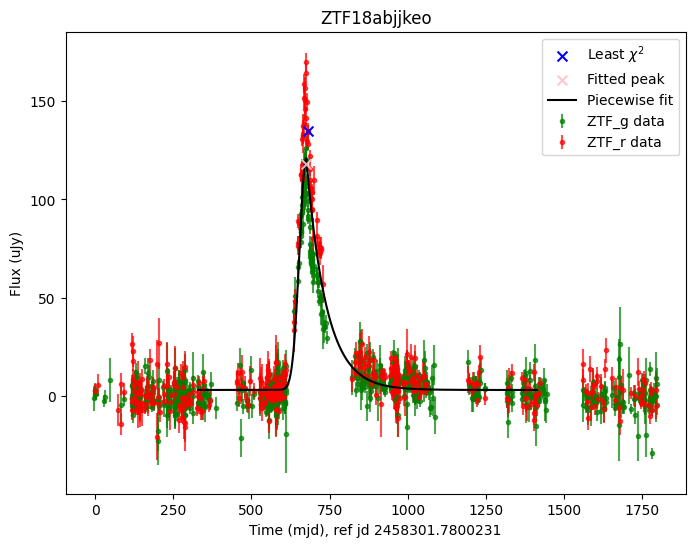

In [53]:
##HAS ERROR, SEE BB_ratio() FOR INFO

# def BB(nu,T):
#     #Blackbody spectrum for a certain frequency given in Hz, not an array of values
#     factor = 2*h*nu**3/(c**2)
#     exponent = (h*nu)/(k*T)
#     return factor /(np.exp(exponent)-1)


def BB_ratio(T):
    exp1 = np.exp((h*v0)/(k*T)) 
    exp2 = np.exp((h*v1)/(k*T)) 
    return v1**3 * (exp1 - 1) / (v0**3 * (exp2 - 1))

def gauss_exp_fit(t,*p):
    Fp = 10**p[0]
    peak_position = p[1]
    sigma_rise = 10**p[2]
    tau_dec = 10**p[3]
    F0 = p[4]
    T = 10**p[5]

    trel = t - peak_position
    gaussian = lambda t: Fp * np.exp(-(np.square(t-peak_position)/(2*sigma_rise**2))) + F0
    exp_decay = lambda t: Fp * np.exp(-(t-peak_position)/tau_dec) + F0

    # trel2 = t - t[np.argmin(gaussian(t)-Fp)]
    # print(trel2)
    function = np.piecewise(t,[trel <= 0,trel>0],[gaussian, exp_decay])
    return function * BB_ratio(T)

def gauss_exp(t,*p):
    Fp = 10**p[0]
    peak_position = p[1]
    sigma_rise = 10**p[2]
    tau_dec = 10**p[3]
    F0 = p[4]
    T = 10**p[5]

    trel = t - peak_position
    gaussian = lambda t: Fp * np.exp(-(np.square(t-peak_position)/(2*sigma_rise**2))) + F0
    exp_decay = lambda t: Fp * np.exp(-(t-peak_position)/tau_dec) + F0

    # trel2 = t - t[np.argmin(gaussian(t)-Fp)]
    # print(trel2)
    function = np.piecewise(t,[trel <= 0,trel>0],[gaussian, exp_decay])
    return function 


popt,pcov,info_dict,_,_ = curve_fit(gauss_exp_fit,time_fit,flux_fit,p0=guesses,bounds=boundings,sigma=err_fit,
                                    full_output=True) 

names = ["log10(Fp)","peak_position","log10(sigma_rise)","log10(tau_dec)","F0","log10(T)"]
display = [f"{names[i]} = {opt}" for i,opt in enumerate(popt)]
print("Popt:",display,'\nErrors',np.diagonal(pcov),'\nRelative error: ',np.diagonal(pcov)/popt)


moretimes = np.linspace(min(time_fit),max(time_fit),2000)
fit = gauss_exp(moretimes,*popt) #fit it to a function that doesn't have the BB ratio
# time = time -  popt[2]

plt.figure(figsize=(8,6))
plt.errorbar(time[greenmask],flux[greenmask],err[greenmask],fmt='.',c='green',label='ZTF_g data',zorder=-1,alpha=0.7)
plt.errorbar(time[~greenmask],flux[~greenmask],err[~greenmask],fmt='.',c='red',label='ZTF_r data',zorder=-1,alpha=0.7)
# plt.scatter(time,flux,s=5,c='black',label='Data')
plt.scatter(time[peak_ind],flux[peak_ind],s=50,marker='x',c='blue',zorder=10,label=r'Least $\chi^2$')
plt.scatter(popt[1],10**popt[0],s=50,marker='x',c='pink',zorder=10,label=r'Fitted peak',alpha=0.9)

plt.plot(moretimes,fit,label='Piecewise fit',zorder=9,c='black')
# plt.vlines(popt[1],0,150,label='Found peak',colors='red')
plt.xlabel(f"Time (mjd), ref jd {time_zeropoint}")
plt.ylabel("Flux (uJy)")
plt.title("ZTF18abjjkeo")
plt.legend()    
plt.show()

# print(fp.chi2(flux,err,model_fit=gauss_exp_fit(moretimes,*popt)))
# print(time_fit,time[peak_ind])

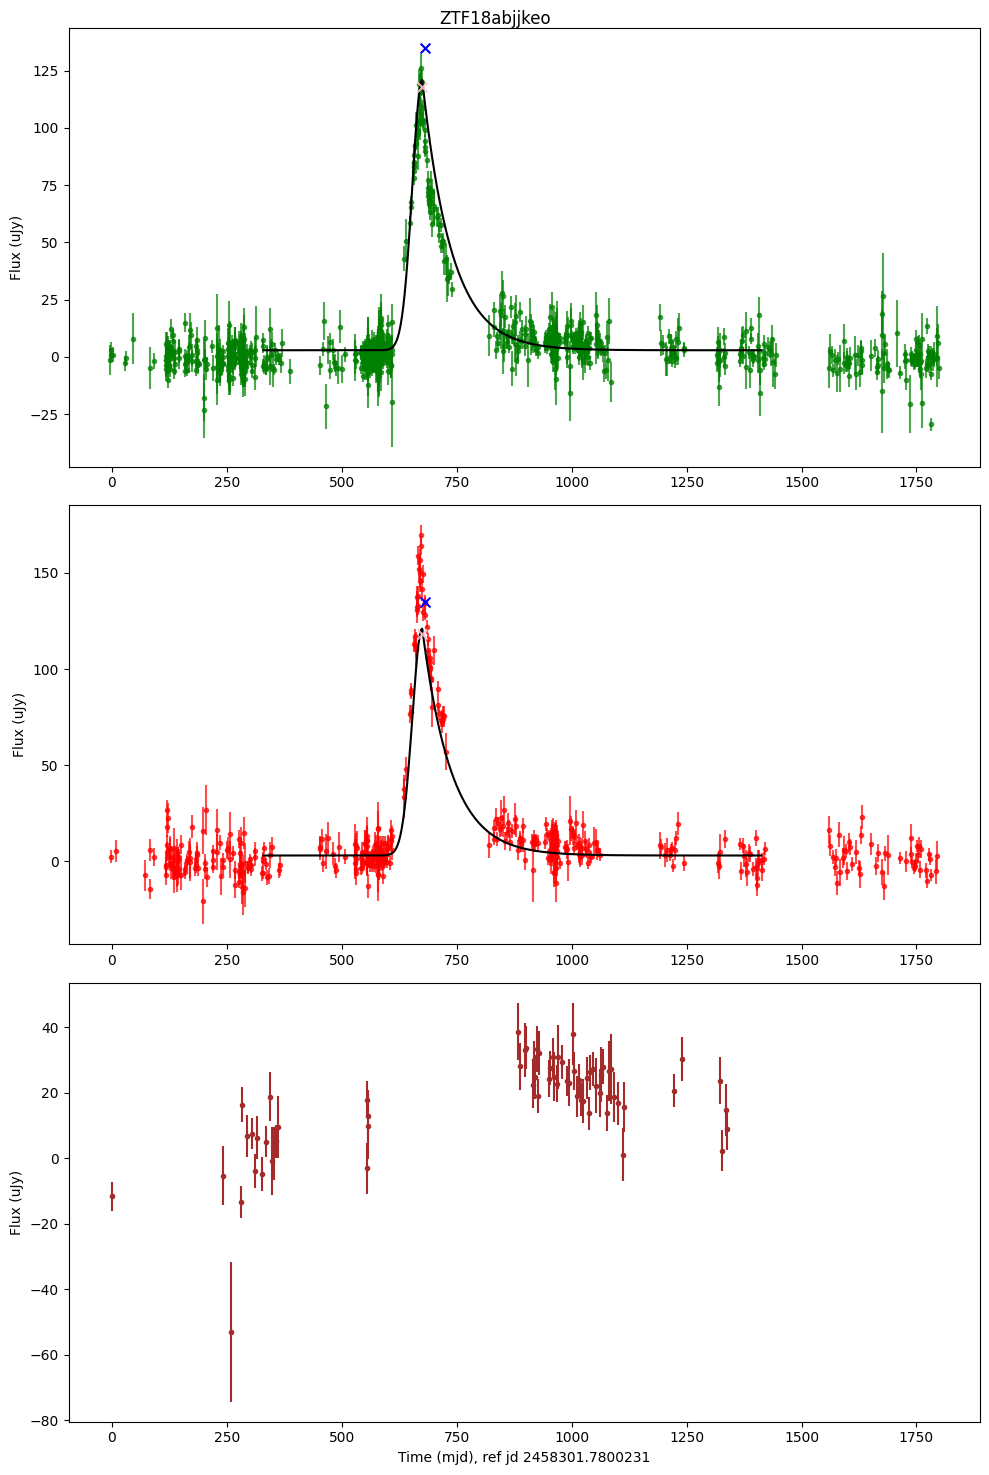

In [50]:
fig,(ax1,ax2,ax3) = plt.subplots(nrows=3,sharex=True,figsize=(10,15))
#dit werkt nog niet omdat we niet een goeie unclean data hebben opgeslagen
# greenmask_full = unclean_data_full['filter'] == 'ZTF_g'
# unclean_flux,unclean_err = fp.flux_jy()
# ax1.errorbar(unclean_data_full['jd'][greenmask_full],unclean_data_full['forcediffimflux'][greenmask_full],testdata_full['flux_unc'][greenmask_full],fmt='.',c='gray',label='unclean',zorder=-1,alpha=0.2)
ax1.xaxis.set_tick_params(which='both', labelbottom=True)
ax2.xaxis.set_tick_params(which='both', labelbottom=True)

ax1.errorbar(time[greenmask],flux[greenmask],err[greenmask],fmt='.',c='green',label='ZTF_g data',zorder=-1,alpha=0.7)
ax2.errorbar(time[~greenmask],flux[~greenmask],err[~greenmask],fmt='.',c='red',label='ZTF_r data',zorder=-1,alpha=0.7)
# plt.scatter(time,flux,s=5,c='black',label='Data')
ax1.scatter(time[peak_ind],flux[peak_ind],s=50,marker='x',c='blue',zorder=10,label=r'Least $\chi^2$')
ax2.scatter(time[peak_ind],flux[peak_ind],s=50,marker='x',c='blue',zorder=10,label=r'Least $\chi^2$')
ax1.scatter(popt[1],10**popt[0],s=50,marker='x',c='pink',zorder=10,label=r'Fitted peak',alpha=0.9)
ax2.scatter(popt[1],10**popt[0],s=50,marker='x',c='pink',zorder=10,label=r'Fitted peak',alpha=0.9)

ax1.plot(moretimes,fit,label='Piecewise fit',zorder=9,c='black')
ax2.plot(moretimes,fit,label='Piecewise fit',zorder=9,c='black')

ax3.errorbar(testdata_full['time'][~no_i_mask],testdata_full['flux'][~no_i_mask],testdata_full['flux_unc'][~no_i_mask],fmt='.',c='brown')

# plt.vlines(popt[1],0,150,label='Found peak',colors='red')
plt.xlabel(f"Time (mjd), ref jd {time_zeropoint}")
ax1.set_ylabel("Flux (uJy)")
ax2.set_ylabel("Flux (uJy)")
ax3.set_ylabel("Flux (uJy)")
plt.suptitle("ZTF18abjjkeo")
# ax1.legend()    
# ax2.legend()    
plt.tight_layout()
plt.show()